In [174]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import rivapy.pricing.analytics
import rivapy.models as models
import rivapy.marketdata as mktdata
%matplotlib inline
#reload modules 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Local-Vol

In [169]:
ssvi = mktdata.VolatilityParametrizationSSVI(expiries=[1.0/365, 30/365, 0.5, 1.0], fwd_atm_vols=[0.25, 0.3, 0.28, 0.25], rho=-0.9, eta=0.5, gamma=0.5)
x_strikes = np.linspace(0.7, 1.3, 50)
time_grid = np.linspace(0.0, 1.0, 80)
local_var = models.LocalVol.compute_local_var(heston_grid_param, x_strikes, time_grid)

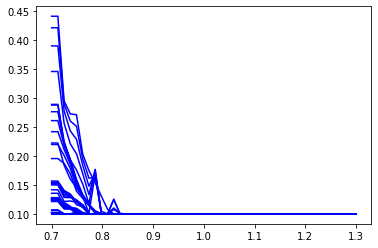

In [171]:
#depp = np.maximum(local_var, 0.1)
for i in range(time_grid.shape[0]):
    plt.plot(x_strikes,depp[i,:],'-b')
    


# Heston

In [102]:
heston = models.HestonModel(long_run_variance=0.3**2, 
                            mean_reversion_speed=0.5, 
                            vol_of_vol=0.2, 
                            initial_variance=0.1**2, 
                            correlation = -0.9)

In [95]:
# compute implied vols for a fixed set of heston parameters

In [103]:
n_sims = 100000
S0 = 1.0

timegrid = np.linspace(0.0,2.0,2*365)

simulated_values = np.empty((n_sims, 2))
simulated_values[:,0] = S0
simulated_values[:,1] = heston._initial_variance

paths = np.empty((timegrid.shape[0], n_sims, 2))
paths[0] = simulated_values

t0 = timegrid[0]
np.random.seed(42)

for i in range(1,timegrid.shape[0]):
    rnd = np.random.normal(size=(n_sims,2))
    paths[i] = heston.apply_mc_step(simulated_values, t0, timegrid[i], rnd, inplace = True)
    t0 = timegrid[i]

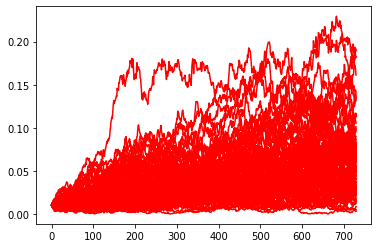

In [104]:
for i in range(100):
    plt.plot(paths[:,i,1],'-r')


expiries = timegrid[10::30]
p = paths[10::30]
strikes = np.linspace(0.7,1.3,40)
call_prices = np.empty((expiries.shape[0], strikes.shape[0]))

for i in range(expiries.shape[0]):
    for k in range(strikes.shape[0]):
        #print(np.mean(np.maximum(paths[10::30][i][:,0]-strikes[k],0.0)))
        call_prices[i,k] = np.mean(np.maximum(p[i][:,0]-strikes[k],0.0))

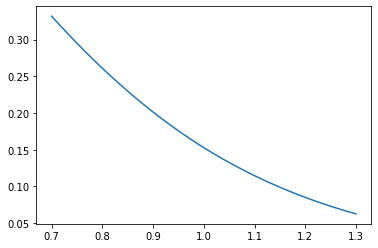

In [91]:
expiry = -1
plt.plot(strikes, call_prices[expiry])
#call_prices

In [147]:
vols = np.zeros((expiries.shape[0],strikes.shape[0]))

import rivapy.pricing.analytics
for i in range(expiries.shape[0]):
    for j in range(strikes.shape[0]):
        try:
            vols[i,j] = rivapy.pricing.analytics.compute_implied_vol_Buehler(strikes[j], maturity=expiries[i], 
                                                              price=call_prices[i, j])
        except:
            pass
for i in range(expiries.shape[0]):
    for j in range(int(strikes.shape[0]/2),strikes.shape[0]):
        if vols[i,j] <1e-1:
            vols[i,j] = vols[i,j-1]
    for j in range(23,-1,-1):
        if vols[i,j] <1e-6:
            vols[i,j] = vols[i,j+1]
                    

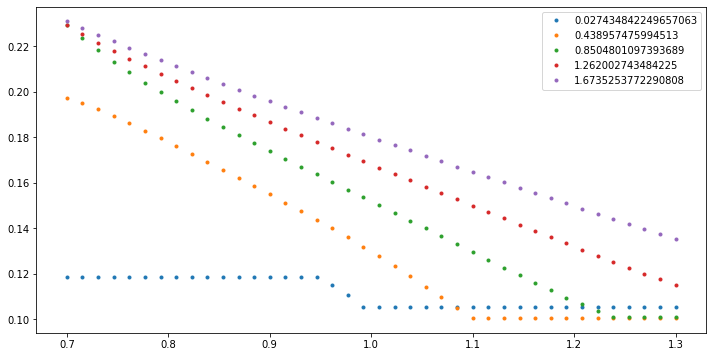

In [148]:
plt.figure(figsize=(12,6))
for i in range(0,expiries.shape[0],5):
    plt.plot(strikes, vols[i,:], '.', label=str(expiries[i]))
plt.legend()

In [149]:
heston_grid_param = mktdata.VolatilityGridParametrization(expiries, strikes, vols)
dc = mktdata.curves.DiscountCurve('dc', dt.datetime(2021,1,1), [dt.datetime(2021,1,1)],[1.0])
heston_surface = mktdata.VolatilitySurface('heston_surface', dt.datetime(2021,1,1), 
                          mktdata.EquityForwardCurve(1.0,dc,dc,dc), 
                         rivapy.enums.DayCounterType.Act365Fixed, grid_param)

# Heston Local-Vol Model

In [188]:
#ssvi = mktdata.VolatilityParametrizationSSVI(expiries=[1.0/365, 30/365, 0.5, 1.0], fwd_atm_vols=[0.25, 0.3, 0.28, 0.25], rho=-0.9, eta=0.5, gamma=0.5)
import pickle

x_strikes = np.linspace(0.7, 1.3, 50)
time_grid = np.linspace(0.0, 1.0, 80)

with open('depp.pck', 'wb') as f:
    #del heston_grid_param._pyvacon_obj
    pickle.dump(heston_grid_param, f)
heston_lv = models.HestonLocalVol(heston)
heston_lv.calibrate_MC(heston_grid_param,  x_strikes=x_strikes, time_grid=time_grid, n_sims=1000) 

AttributeError: 'VolatilityGridParametrization' object has no attribute '_pyvacon_obj'

In [ ]:
plt.plot(heston_lv.calibrate)